<a href="https://colab.research.google.com/github/Sulfika715/DeepLearning/blob/master/Increption_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/'My Drive'

/content/drive/My Drive


In [3]:
import numpy as np
import pickle
import cv2
import keras

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.layers import BatchNormalization

from os import listdir
from keras import backend as K
from keras.layers import Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((299, 299))
image_size = 0
directory_root = './dataset/'
width=299
height=299
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Image loading completed
CPU times: user 507 µs, sys: 0 ns, total: 507 µs
Wall time: 512 µs


In [0]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
base_model = InceptionV3(weights=None, include_top=False, input_tensor=Input(shape = (width, height, depth)))

x = base_model.output
output = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[INFO] training network...


In [14]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )



Epoch 1/50
30/30 [==============================] - 72s 2s/step - loss: 0.6241 - acc: 0.8224 - val_loss: 4.2721 - val_acc: 0.7292
Epoch 2/50
30/30 [==============================] - 36s 1s/step - loss: 0.5315 - acc: 0.8342 - val_loss: 4.2170 - val_acc: 0.7340
Epoch 3/50
30/30 [==============================] - 36s 1s/step - loss: 0.6032 - acc: 0.8293 - val_loss: 4.3415 - val_acc: 0.7292
Epoch 4/50
30/30 [==============================] - 36s 1s/step - loss: 0.4861 - acc: 0.8365 - val_loss: 4.5050 - val_acc: 0.7153
Epoch 5/50
30/30 [==============================] - 36s 1s/step - loss: 0.5189 - acc: 0.8304 - val_loss: 3.4130 - val_acc: 0.7319
Epoch 6/50
30/30 [==============================] - 36s 1s/step - loss: 0.3968 - acc: 0.8394 - val_loss: 0.8435 - val_acc: 0.8125
Epoch 7/50
30/30 [==============================] - 36s 1s/step - loss: 0.3310 - acc: 0.8606 - val_loss: 0.6389 - val_acc: 0.8389
Epoch 8/50
30/30 [==============================] - 36s 1s/step - loss: 0.3359 - acc: 0.

In [15]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

240/240 [==============================] - 3s 12ms/step
Test Accuracy: 91.45833452542624


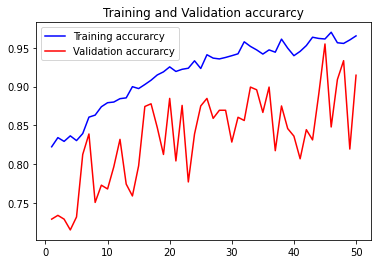

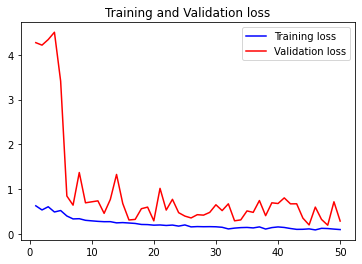

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()